In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.dataviz import plot_raster
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import _pipeline

In [ ]:
path="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/in_out_b1_b2/2025_01_03_12_05_07/pfc/population.h5"

In [ ]:
popu = PopulationData.from_python_hdf5(path)

KeyboardInterrupt: 

In [ ]:
start_sample = 0
end_sample = 400

In [ ]:
st_target = 0
end_target = 450
cerotr, percentile=True,True
st_bl = -100
end_bl = 0

In [ ]:
allres=[]
for i,neu in enumerate(popu.population[1462:1554]):
    res = _pipeline.get_space_neutral_roc(
        neu,
        start_sample,
        end_sample,
        st_target,
        end_target,
        st_bl,
        end_bl,
        cerotr=cerotr,
        percentile=percentile,
    )
    allres.append(res)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
neu.date_time

'2022-12-16_10-30-59'

In [ ]:
popu.population[1]

In [ ]:
df = pd.DataFrame(allres)

In [ ]:
df['neutral_idx'] = df['neutral_in']-df['neutral_out']
df['spatial_idx'] = df['space_in']-df['space_out']
df

,nid,neutral_in,neutral_out,space_in,space_out,neutral_idx,spatial_idx
0,2022-12-13_11-11-42_Riesling_pfc_e1_r1_good1,-0.184143,0.348894,0.420118,0.000000,-0.533038,0.420118
1,2022-11-28_10-23-27_Riesling_pfc_e1_r1_good2,NaN,NaN,0.000000,NaN,NaN,NaN
2,2022-12-13_11-11-42_Riesling_pfc_e1_r1_mua3,-0.106200,0.133308,0.273333,-0.295139,-0.239508,0.568472
3,2022-12-13_11-11-42_Riesling_pfc_e1_r1_mua4,0.382453,0.078375,0.000000,-0.359504,0.304078,0.359504
4,2022-12-13_11-11-42_Riesling_pfc_e1_r1_mua5,0.165733,0.255308,0.256944,0.155000,-0.089575,0.101944
...,...,...,...,...,...,...,...
395,2022-12-01_12-01-59_Riesling_pfc_e1_r1_mua32,0.479718,0.232673,NaN,NaN,0.247045,NaN
396,2022-12-01_12-01-59_Riesling_pfc_e1_r1_good15,-0.162222,-0.375681,NaN,NaN,0.213458,NaN
397,2022-12-01_12-01-59_Riesling_pfc_e1_r1_mua33,0.255576,0.229072,NaN,NaN,0.026503,NaN
398,2022-12-01_12-01-59_Riesling_pfc_e1_r1_mua34,0.000000,-0.362520,NaN,NaN,0.362520,NaN


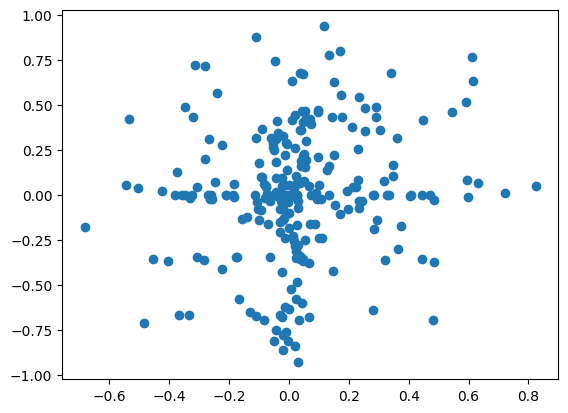

In [ ]:
plt.scatter(df['neutral_idx'],df['spatial_idx'])

In [ ]:
res

{'neutra_in': -0.10758774097874446,
 'neutra_out': 0.12392344497607655,
 'space_in': -0.31,
 'space_out': -0.30578512396694213}

In [ ]:
from ephysvibe.dataviz import plot_raster

In [ ]:
nid = neu.get_neuron_id() 
path=f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
neu_n = NeuronData.from_python_hdf5(path)


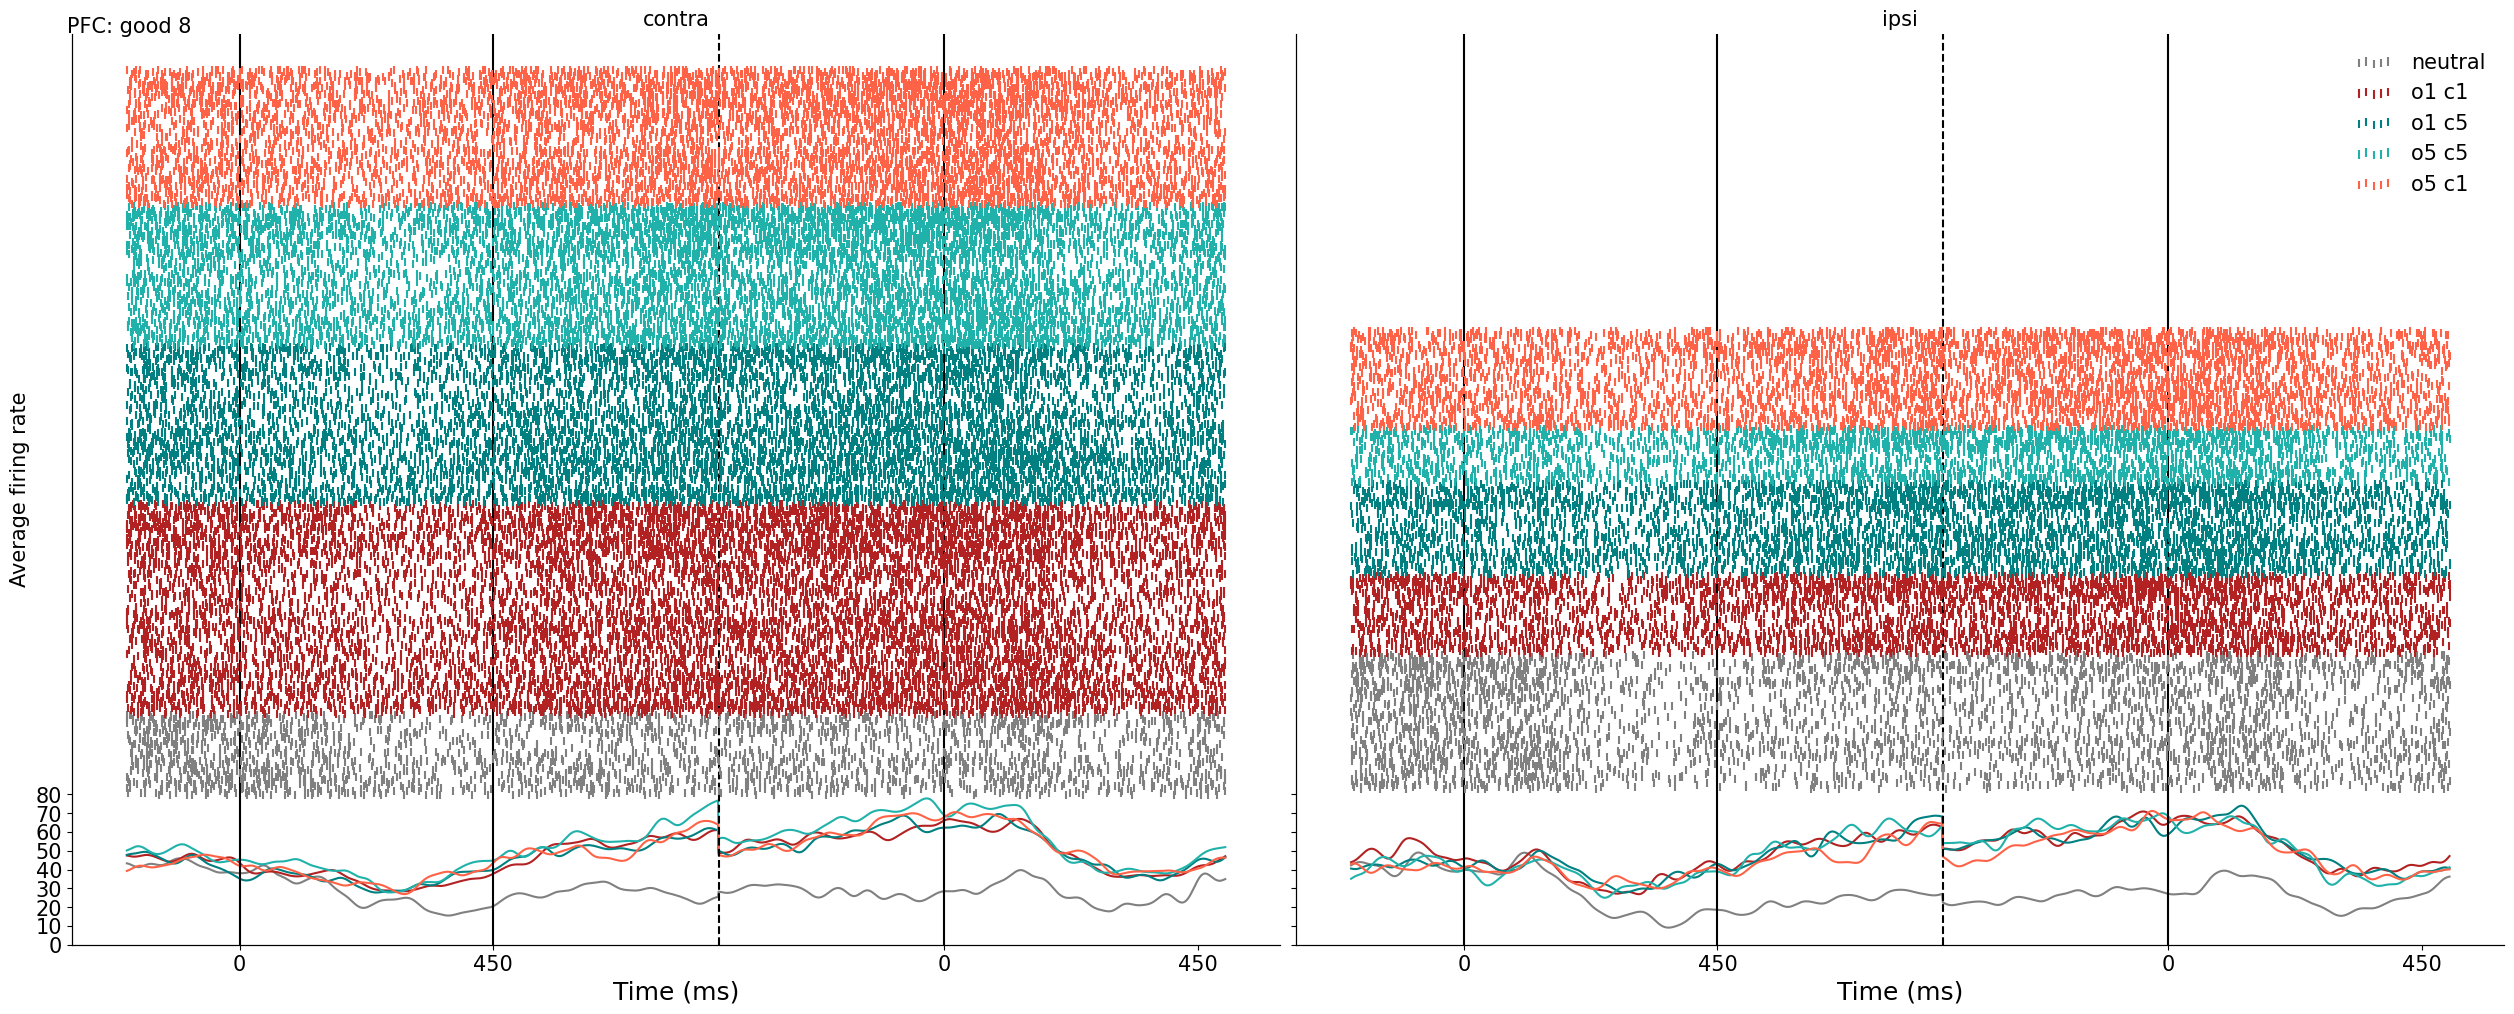

In [ ]:
sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=plot_raster.plot_sp_b1(neu_n,sp, conv)

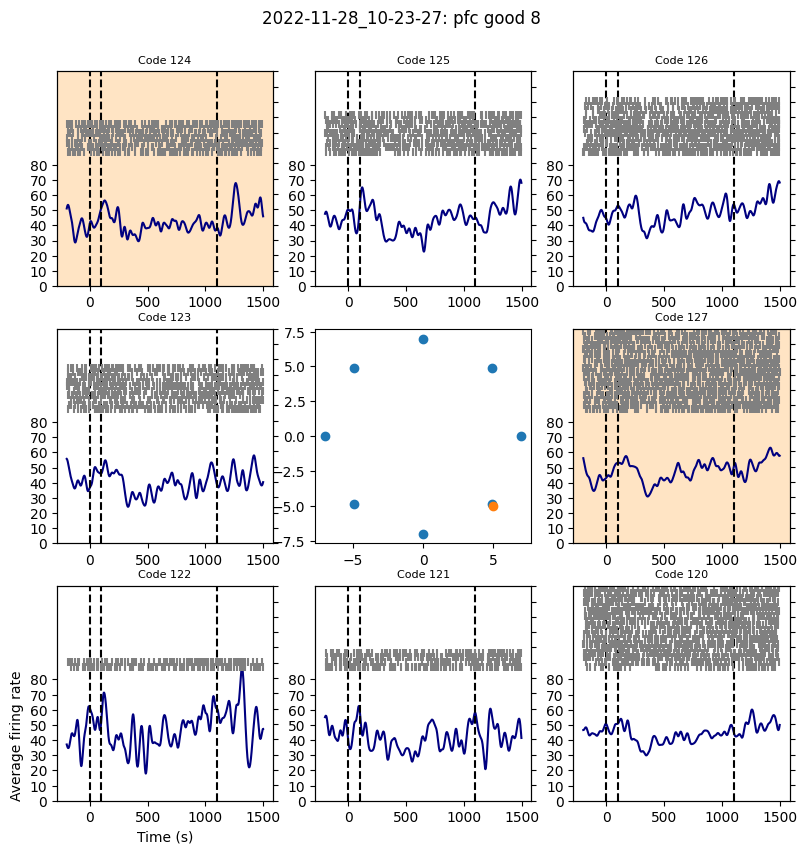

In [ ]:
sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
fig = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)